In [74]:
import os
import sys
sys.path.append('../')

from helpers import helper
from networks import Unet
import config

import cv2
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

device = config.get_device()

networks = {
    "Unet": Unet,
}

network = networks["Unet"].get_model()
network_dir = network.get_network_dir()
interval = 30

Using device: cuda
Load model from ../models/unet_default.pth


In [75]:
# takes in a single image and outputs the predicted label
def experiment(network, device, image_path, output_path=""):
    network.eval()
    network.to(device)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = config.transform(image).unsqueeze(0)
    output = network(image.to(device))
    if output_path != "":
        helper.save_tensor_output(output[0], output_path)
    
    return output[0]

# create the output directory if it doesn't exist
if not os.path.exists(f'../../datasets/experiment/outputs/{network_dir}'):
    os.makedirs(f'../../datasets/experiment/outputs/{network_dir}')

for slash_degree in tqdm(np.arange(0, 80.0, 0.5)):
    for thickness in range(1, 5):
        image_path = f'../../datasets/experiment/images/image_{slash_degree}_{thickness}_{interval}.png'
        output_path = f'../../datasets/experiment/outputs/{network_dir}/image_{slash_degree}_{thickness}_{interval}.png'
        # get the network and its output directory
        output = experiment(network, device, image_path=image_path, output_path=output_path)


100%|██████████| 160/160 [01:36<00:00,  1.67it/s]


In [77]:
def draw_mask_slash(mask, center, length, degree, thickness, color):
    # Draw line on image
    angular = helper.convertDegreeToRadian(degree)
    x1 = int(center[0] + length * np.cos(angular))
    y1 = int(center[1] + length * np.sin(angular))
    x2 = int(center[0] - length * np.cos(angular))
    y2 = int(center[1] - length * np.sin(angular))

    mask = cv2.line(mask, (x1, y1), (x2, y2), color, thickness)
    return mask

def get_mask(thickess, degree, interval):
    left_mask = np.zeros((256, 256), np.uint8)
    right_mask = np.zeros((256, 256), np.uint8)
    
    left_mask = draw_mask_slash(left_mask, (config.LEFT_POS, 128), 100, 90, thickess, 1)
    right_mask = draw_mask_slash(right_mask, (config.RIGHT_POS, 128), 110, 90, thickess, 1)

    for i in range(50, 225, interval):
        draw_mask_slash(left_mask, (config.LEFT_POS, i), 20, degree, 4, 0)
        draw_mask_slash(right_mask, (config.RIGHT_POS, i), 20, 180-degree, 4, 0)

    return left_mask, right_mask

def get_orientation(output_HSV, left_mask, right_mask):
    hue = output_HSV[:, :, 0]
    left_angle = np.mean(hue[left_mask == 1])
    right_angle = np.mean(hue[right_mask == 1])
    return left_angle, right_angle

slash_degree = 10.0
thickness = 3

output = cv2.imread(f"../../datasets/experiment/outputs/{network_dir}/image_{slash_degree}_{thickness}_{interval}.png")
output_HSV = cv2.cvtColor(output, cv2.COLOR_BGR2HSV)
left_mask, right_mask = get_mask(thickness, slash_degree, 30)

get_orientation(output_HSV, left_mask, right_mask)


(91.10081112398609, 90.12876427829698)

In [80]:
predictions = {
    "left": [[] for _ in range(4)],
    "right": [[] for _ in range(4)],
    "slash" : []
}

# read angle from output
for slash_degree in tqdm(np.arange(0, 80, 0.5)):
    predictions["slash"].append(slash_degree)
    for thickness in range(1, 5):
        output = cv2.imread(f"../../datasets/experiment/outputs/{network_dir}/image_{slash_degree}_{thickness}_{interval}.png")
        output_HSV = cv2.cvtColor(output, cv2.COLOR_BGR2HSV)
        left_mask, right_mask = get_mask(thickness, slash_degree, 30)
        left_angle, right_angle = get_orientation(output_HSV, left_mask, right_mask)
        predictions["left"][thickness-1].append(left_angle)
        predictions["right"][thickness-1].append(right_angle)


100%|██████████| 160/160 [00:01<00:00, 111.68it/s]


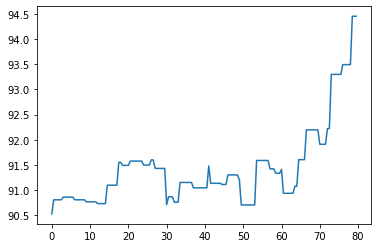

In [91]:
plt.plot(predictions["slash"], predictions["left"][0])